# Catching Hackers
For this chapter, we will be simulating the data we will work with using the [`login_attempt_simulator` package](https://github.com/stefmolin/login-attempt-simulator). The simulator needs to generate random numbers from various distributions. Here is an example of each of them:

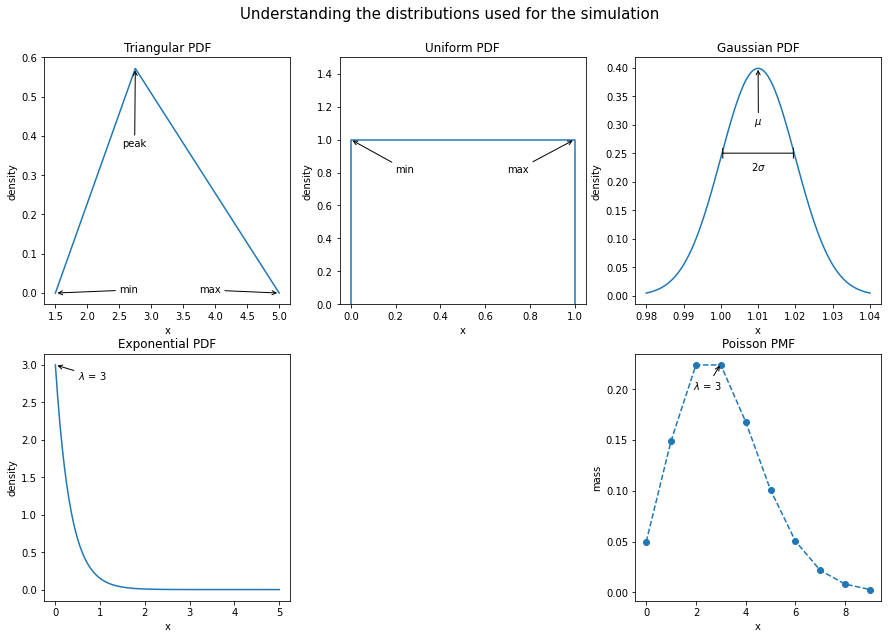

In [1]:
%matplotlib inline
import visual_aids

_ = visual_aids.show_distributions()

*Note: the Poisson distribution is discrete while the others are continuous. We use the Poisson distributions to model arrivals (users coming to login for this example). Discrete distributions have PMFs (probability mass functions) instead of PDFs.*

The `simulate.py` script can be run from the command line to run the simulation:

In [2]:
!python simulate.py -h

usage: simulate.py [-h] [-m] [-s SEED] [-u USERBASE] [-i IP] [-l LOG]
                   [-hl HACKLOG]
                   days start_date

positional arguments:
  days                  number of days to simulate from start
  start_date            datetime to start in the form 'YYYY-MM-DD' or 'YYYY-
                        MM-DD-HH'

optional arguments:
  -h, --help            show this help message and exit
  -m, --make            make userbase
  -s SEED, --seed SEED  set a seed for reproducibility
  -u USERBASE, --userbase USERBASE
                        file to write the userbase to
  -i IP, --ip IP        file to write the user-ip address map to
  -l LOG, --log LOG     file to write the attempt log to
  -hl HACKLOG, --hacklog HACKLOG
                        file to write the hack log to


We will simulate November 2019 using a seed of 0 and making the userbase:

In [3]:
!python simulate.py -ms 0 30 "2019-11-01"

[WARNING] [ simulate.py ] Creating new user base and mapping IP addresses to them.
[INFO] [ simulate.py ] Simulating 30.0 days...
[INFO] [ simulate.py ] Saving logs
[INFO] [ simulate.py ] All done!


## Setup

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

log = pd.read_csv('logs/log.csv', index_col='datetime', parse_dates=True)
attacks = pd.read_csv(
    'logs/attacks.csv',
    converters={'start' : np.datetime64, 'end': np.datetime64}
) # make start and end columns datetimes but not the index

## Understanding the Data
The login attempts recorded from the website look like this:

In [5]:
log.head()

,source_ip,username,success,failure_reason
datetime,,,,
2019-11-01 00:36:52.617978,142.89.86.32,vkim,True,NaN
2019-11-01 01:00:23.166623,5.118.187.36,kkim,True,NaN
2019-11-01 01:31:50.779608,142.89.86.32,vkim,False,error_wrong_password
2019-11-01 01:31:51.779608,142.89.86.32,vkim,True,NaN
2019-11-01 01:32:44.016230,15.176.178.91,kkim,True,NaN


The labeled data we have to research how to detect the attackers looks like this:

In [6]:
attacks.head()

,start,end,source_ip
0,2019-11-02 05:06:17.152636,2019-11-02 05:10:30.152636,212.79.15.228
1,2019-11-02 07:24:27.930550,2019-11-02 07:25:12.930550,164.200.54.24
2,2019-11-02 15:24:17.496767,2019-11-02 15:27:53.496767,106.44.211.210
3,2019-11-02 21:26:27.155130,2019-11-02 21:27:42.155130,44.238.133.131
4,2019-11-02 23:20:19.887171,2019-11-02 23:24:24.887171,16.117.91.5


We had 60 attacks in 11,235 attempts:

In [7]:
attacks.shape, log.shape

((60, 3), (11235, 4))

What percentage of IP addresses were from attackers?

In [8]:
attacks.source_ip.nunique() / log.source_ip.nunique()

0.18808777429467086

## EDA
Can we find suspicious activity looking at hourly attempts to log in?

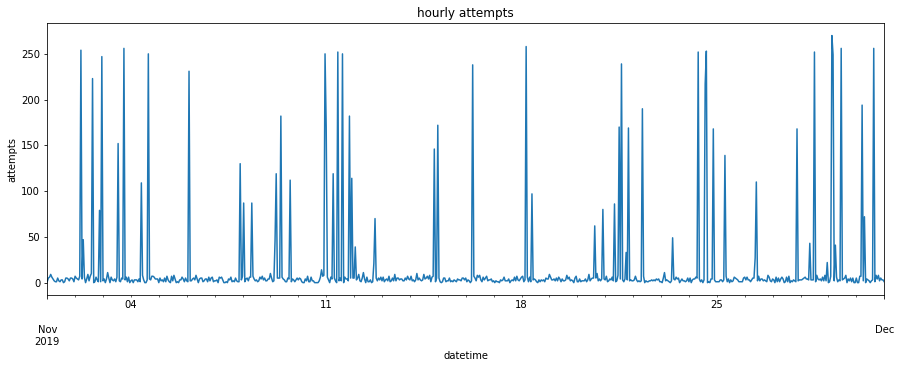

In [9]:
# attempts over time
log.assign(attempts=1).attempts.resample('1H').sum().plot(
    figsize=(15, 5), title='hourly attempts'
)
plt.xlabel('datetime')
plt.ylabel('attempts')
plt.savefig('hourly_attempts.png', bbox_inches='tight')

How many attempts came from each IP address?

In [10]:
log.source_ip.value_counts().describe()

count    319.000000
mean      35.219436
std       65.510253
min        1.000000
25%        5.000000
50%        9.000000
75%       17.000000
max      262.000000
Name: source_ip, dtype: float64

What does the distribution of attempts per IP address look like?

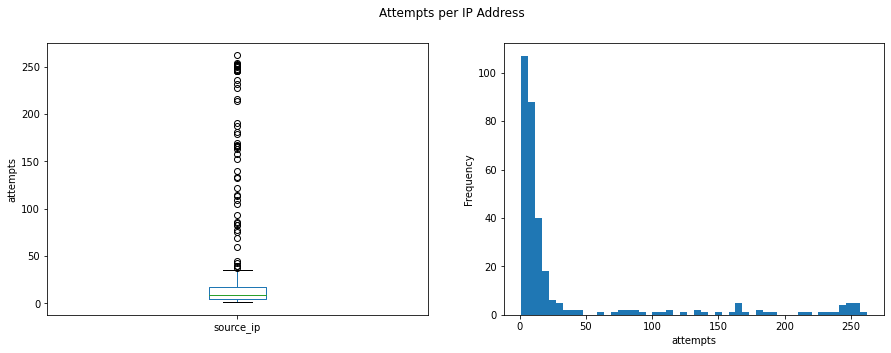

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
log.source_ip.value_counts().plot(kind='box', ax=axes[0]).set_ylabel('attempts')
log.source_ip.value_counts().plot(kind='hist', bins=50, ax=axes[1]).set_xlabel('attempts')
fig.suptitle('Attempts per IP Address')
plt.savefig('attempts_per_ip_address.png', bbox_inches='tight')

What percent of the top IP addresses are hackers?

In [12]:
num_hackers = attacks.source_ip.shape[0]
log.source_ip.value_counts().index[:num_hackers]\
    .isin(attacks.source_ip).sum() / num_hackers

0.9166666666666666

What does the average hourly attempts per IP address look like over the time period?

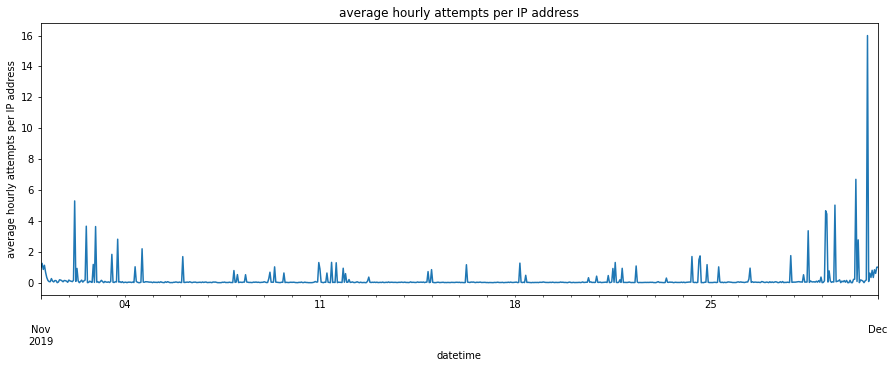

In [13]:
# attempts per ip address
log.assign(attempts=1).groupby('source_ip').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per IP address')\
    .set_ylabel('average hourly attempts per IP address')
plt.savefig('average_hourly_attempts_per_ip_address.png', bbox_inches='tight')

What percent of the time was a hacker's attempt successful?

In [14]:
log[log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

False    0.829365
True     0.170635
Name: success, dtype: float64

What percent of the time are valid users' attempts successful?

In [15]:
log[~log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

True     0.888795
False    0.111205
Name: success, dtype: float64

Why is each group failing?

In [16]:
pd.crosstab(
    index=pd.Series(
        log.source_ip.isin(attacks.source_ip), name='is_hacker'
    ), columns=log.failure_reason
)

failure_reason,error_wrong_password,error_wrong_username
is_hacker,,
False,263,1
True,2938,4411


How many times does a user try to log in per hour? Valid users don't make many mistakes with their credentials, so if the hackers make many attempts with many users, we flag it.

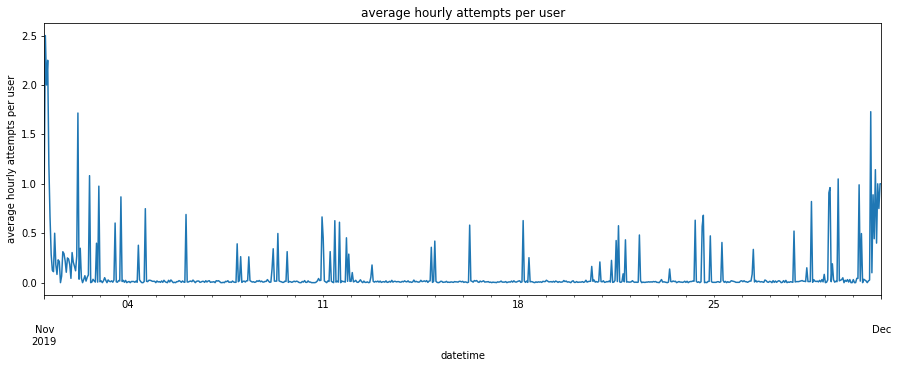

In [17]:
# attempts per user
log.assign(attempts=1).groupby('username').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per user')\
    .set_ylabel('average hourly attempts per user')
plt.savefig('average_hourly_attempts_per_user.png', bbox_inches='tight')

Calculate metrics per IP address

In [18]:
pivot = pd.pivot_table(
    log, values='success', index=log.source_ip, 
    columns=log.failure_reason.fillna('success'), 
    aggfunc='count', fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values('attempts', ascending=False).assign(
    success_rate=lambda x: x.success / x.attempts,
    error_rate=lambda x: 1 - x.success_rate
)
pivot.head()

failure_reason,attempts,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,
167.93.191.168,262,81,146,35,0.133588,0.866412
233.248.207.107,254,71,142,41,0.161417,0.838583
212.79.15.228,253,89,127,37,0.146245,0.853755
199.64.210.174,252,76,135,41,0.162698,0.837302
204.181.46.160,252,82,127,43,0.170635,0.829365


Most successful IP addresses:

In [19]:
pivot.sort_values('success_rate', ascending=False).head()

failure_reason,attempts,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,
196.251.56.30,9,0,0,9,1.0,0.0
85.192.44.33,13,0,0,13,1.0,0.0
198.119.10.0,7,0,0,7,1.0,0.0
130.243.110.172,7,0,0,7,1.0,0.0
131.79.194.150,7,0,0,7,1.0,0.0


What looks out of place with the five-number summary?

In [20]:
pivot.describe()

failure_reason,attempts,error_wrong_password,error_wrong_username,success,success_rate,error_rate
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,35.219436,10.034483,13.830721,11.354232,0.771171,0.228829
std,65.510253,22.567343,34.120249,10.632656,0.297493,0.297493
min,1.000000,0.000000,0.000000,1.000000,0.033333,0.000000
25%,5.000000,0.000000,0.000000,5.000000,0.750000,0.000000
50%,9.000000,1.000000,0.000000,8.000000,0.882353,0.117647
75%,17.000000,3.000000,0.000000,13.500000,1.000000,0.250000
max,262.000000,94.000000,146.000000,59.000000,1.000000,0.966667


Are there IP addresses being used with many distinct usernames?

In [21]:
log.groupby('source_ip').agg(
    dict(username='nunique')
).username.value_counts().describe()

count     50.000000
mean       6.380000
std       36.603161
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      260.000000
Name: username, dtype: float64

### Visual Anomaly Detection
We had a bimodal distribution of attempts per IP address--will we have two clusters when we plot successes vs. attempts by IP address:

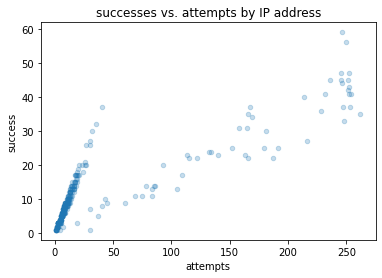

In [22]:
pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)
plt.savefig('successes_vs_attempts.png', bbox_inches='tight')

Perhaps we can draw a boundary between these groups:

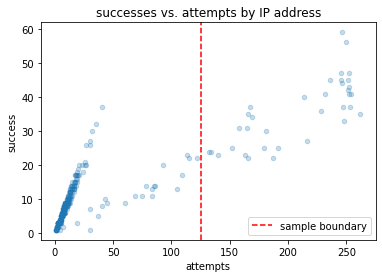

In [23]:
ax = pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)
plt.axvline(125, label='sample boundary', color='red', linestyle='--')
plt.legend(loc='lower right')
plt.savefig('sample_boundary.png', bbox_inches='tight')

Since we are in the research phase, we have some labeled data, so we can see if our boundary was correct:

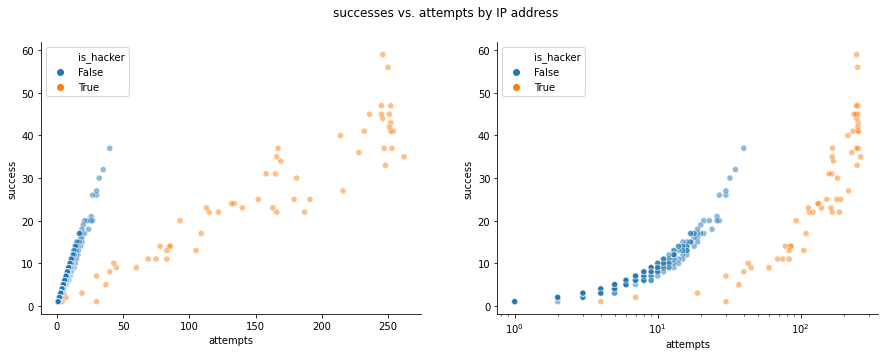

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax in axes:
    sns.scatterplot(
        y=pivot.success, x=pivot.attempts, 
        hue=pivot.assign(
            is_hacker=lambda x: x.index.isin(attacks.source_ip)
        ).is_hacker,
        ax=ax, alpha=0.5
    )
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
axes[1].set_xscale('log')
plt.suptitle('successes vs. attempts by IP address')
plt.savefig('hourly_attempts_labeled.png', bbox_inches='tight')

Can a box plot show us outliers corresponding to the top right cluster in the previous scatter plots?

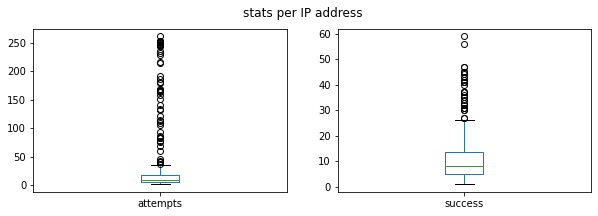

In [25]:
pivot[['attempts', 'success']].plot(
    kind='box', subplots=True, figsize=(10, 3),
    title='stats per IP address'
)
plt.savefig('stats_per_ip_address.png', bbox_inches='tight')

## Rule-based Anomaly Detection
We want to find the IP addresses with excessive amounts of attempts with low success rates and those attempting to log in with more unique usernames than we would deem normal (anomalies).

In [26]:
hourly_ip_logs = log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').resample('1H').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

The data we will use for rule-based anomaly detection looks like this:

In [27]:
hourly_ip_logs.head()

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,1.138.149.116,2019-11-01 04:00:00,1,5,1,6,0.833333,0.166667
1,1.138.149.116,2019-11-07 02:00:00,1,3,0,3,1.000000,0.000000
2,1.138.149.116,2019-11-08 20:00:00,1,2,0,2,1.000000,0.000000
3,1.138.149.116,2019-11-08 21:00:00,1,2,0,2,1.000000,0.000000
4,1.138.149.116,2019-11-20 00:00:00,1,1,0,1,1.000000,0.000000


### Percent Difference from Threshold
A simple rule would be to check if values are a certain percentage or more different from some threshold. 

#### Bootstrapping
In our case, the threshold will be an hourly baseline of login activity. We could use bootstrapping to calculate the baseline with random sample of size 10 for each hour:

In [28]:
def get_baselines(hourly_ip_logs, func, *args, **kwargs):
    """
    Calculate hourly bootstrapped statistic per column.
    
    Parameters:
        - hourly_ip_logs: Data to sample from.
        - func: Statistic to calculate.
        - args: Additional positional arguments for `func`
        - kwargs: Additional keyword arguments for `func`
    
    Returns:
        A pandas DataFrame of hourly bootstrapped statistics
    """
    if isinstance(func, str):
        func = getattr(pd.DataFrame, func)
    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).groupby('hour').apply(
        lambda x: x.sample(10, random_state=0, replace=True).pipe(func, *args, **kwargs, numeric_only=True)
    )

When we run our function, we get a bootstrapped hourly average to use as a baseline:

In [29]:
averages = get_baselines(hourly_ip_logs, 'mean')
averages.shape

(24, 7)

This technique however doesn't guarantee we won't mix any of the hacker activity into our baseline calculations. We might find it difficult to flag any activity at 12AM with this method. Our valid users may well be asleep, but we won't notice the attack with this baseline.

In [30]:
averages.head()

,username,success,failures,attempts,success_rate,failure_rate,hour
hour,,,,,,,
0,10.4,3.6,14.1,17.7,0.864110,0.135890,0.0
1,1.0,1.4,0.3,1.7,0.866667,0.133333,1.0
2,1.0,1.9,0.3,2.2,0.883333,0.116667,2.0
3,1.0,1.9,0.1,2.0,0.950000,0.050000,3.0
4,5.0,2.5,7.3,9.8,0.803333,0.196667,4.0


#### Trimming
We need to remove some of the outliers for better baselines. Let's write a function to trim values beyond a given quantile:

In [31]:
def trim(x, quantile):
    """Remove rows with entries for the username, attempts, or failure_rate columns above a given quantile."""
    mask = ((x.username <= x.username.quantile(quantile))\
        & (x.attempts <= x.attempts.quantile(quantile))\
        & (x.failure_rate <= x.failure_rate.quantile(quantile)))
    return x[mask]

This function can be used when we run `apply()` after a `groupby()`:

In [32]:
trimmed_hourly_logs = hourly_ip_logs.assign(
    hour=lambda x: x.datetime.dt.hour
).groupby('hour').apply(
    lambda x: trim(x, 0.95)
).drop(columns='hour').reset_index().iloc[:,2:]

In [33]:
trimmed_hourly_logs.head()

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,1.138.149.116,2019-11-20,1,1,0,1,1.0,0.0
1,101.113.31.197,2019-11-03,1,2,0,2,1.0,0.0
2,105.148.213.246,2019-11-04,1,1,0,1,1.0,0.0
3,107.177.96.103,2019-11-09,1,1,0,1,1.0,0.0
4,109.120.67.119,2019-11-08,1,2,0,2,1.0,0.0


Our trimmed baseline doesn't have really large values for 12AM anymore:

In [34]:
averages = get_baselines(trimmed_hourly_logs, 'mean')
averages.head()

,username,success,failures,attempts,success_rate,failure_rate,hour
hour,,,,,,,
0,1.0,2.0,0.3,2.3,0.866667,0.133333,0.0
1,1.0,1.3,0.2,1.5,0.916667,0.083333,1.0
2,1.0,1.6,0.2,1.8,0.933333,0.066667,2.0
3,1.0,2.3,0.1,2.4,0.950000,0.050000,3.0
4,1.0,1.9,0.2,2.1,0.933333,0.066667,4.0


Next, we need a function to determine when our thresholds are exceeded. Our threshold will be some percentage of the baseline:

In [35]:
def pct_change_threshold(hourly_ip_logs, baselines, pcts=None):
    """
    Return flagged IP addresses based on thresholds.
    
    Parameters:
        - hourly_ip_logs: Aggregated hourly data per IP address.
        - baselines: Hourly baselines per column in data.
        - pcts: Dictionary of custom percentages per column for
                calculating upper bound thresholds (baseline * pct).
                If not provided, pct will be 1.
    
    Returns:
        Pandas series containing the IP addresses flagged.
    """
    pcts = {} if not pcts else pcts

    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).join(
        baselines, on='hour', rsuffix='_baseline'
    ).assign(
        too_many_users=lambda x: x.username_baseline \
            * pcts.get('username', 1) <= x.username,
        too_many_attempts=lambda x: x.attempts_baseline \
            * pcts.get('attempts', 1) <= x.attempts,
        high_failure_rate=lambda x: x.failure_rate_baseline \
            * pcts.get('failure_rate', 1) <= x.failure_rate
    ).query(
        'too_many_users and too_many_attempts and high_failure_rate'
    ).source_ip.drop_duplicates()

Let's see how many IP addresses get flagged for being 25% greater than the mean baselines for distinct usernames, number of attempts, and failure rate:

In [36]:
pct_from_mean_ips = pct_change_threshold(
    hourly_ip_logs, averages, 
    {key: 1.25 for key in ['username', 'attempts', 'failure_rate']}
)
pct_from_mean_ips.nunique()

59

### Tukey Fence
Another strategy is to use the upper bound of the Tukey fence. The multiplier on the IQR is a parameter we will want to tune:

In [38]:
def tukey_fence_test(trimmed_data, logs, k, pct=None):
    """
    See which IP addresses get flagged with a Tukey Fence with
    multiplier k and optional percent differences.
    
    Parameters: 
        - trimmed_data: The data to use to calculate the baselines
        - logs: The data to test
        - k: The Tukey fence multiplier
        - pct: Dictionary of percentages per column for use with `pct_change_threshold()`
        
    Returns:
        A pandas Series of flagged IP addresses
    """
    q3 = get_baselines(trimmed_data, 'quantile', .75).drop(columns=['hour'])
    q1 = get_baselines(trimmed_data, 'quantile', .25).drop(columns=['hour'])
    iqr = q3 - q1
    upper_bound = (q3 + k*iqr).reset_index()
    return pct_change_threshold(logs, upper_bound, pct)

Let's see what gets flagged with using a Tukey fence upper bound with a multiplier of 3:

In [39]:
tukey_fence_flags = tukey_fence_test(
    trimmed_hourly_logs, hourly_ip_logs, k=3
)

We once again use `nunique()` to see the number of items flagged:

In [40]:
tukey_fence_flags.nunique()

131

### Z-score
We can use the Z-score to flag values beyond a certain number of standard deviations above the mean:

In [41]:
def z_score_test(trimmed_data, logs, cutoff):
    """
    See which IP addresses get flagged with a Z-score greater than
    or equal to a cutoff value.
    
    Parameters: 
        - trimmed_data: The data to use to calculate the baselines
        - logs: The data to test
        - cutoff: Flag row when z_score >= cutoff
        
    Returns:
        A pandas Series of flagged IP addresses
    """
    std_dev = get_baselines(trimmed_data, 'std').drop(columns=['hour'])
    averages = get_baselines(trimmed_data, 'mean').drop(columns=['hour'])

    return logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).join(
        std_dev.join(
            averages, 
            lsuffix='_std', 
            rsuffix='_mean'
        ),
        on='hour'
    ).assign(
        too_many_users=lambda x: (
            x.username - x.username_mean
        )/x.username_std >= cutoff,
        too_many_attempts=lambda x:  (
            x.attempts - x.attempts_mean
        )/x.attempts_std >= cutoff,
        high_failure_rate=lambda x:  (
            x.failure_rate - x.failure_rate_mean
        )/x.failure_rate_std >= cutoff
    ).query(
        'too_many_users and too_many_attempts and high_failure_rate'
    ).source_ip.drop_duplicates()

z_score_ips = z_score_test(trimmed_hourly_logs, hourly_ip_logs, 3)
z_score_ips.nunique()

49

### Evaluating Methods
This is a classification problem with 4 outcomes:

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Predicted'>

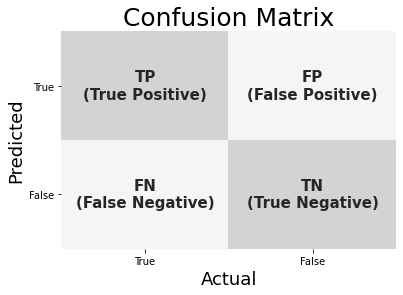

In [42]:
visual_aids.confusion_matrix()

We can write a function to calculate the metrics of the confusion matrix:

In [43]:
def evaluate(alerted_ips, attack_ips, log_ips):
    """
    Calculate true positives (TP), false positives (FP), 
    true negatives (TN), and false negatives (FN) for 
    IP addresses flagged as suspicious.
    
    Parameters:
        - alerted_ips: Pandas series of flagged IP addresses
        - attack_ips: Pandas series of attacker IP addresses
        - log_ips: Pandas series of all IP addresses seen
    
    Returns:
        Tuple of form (TP, FP, TN, FN)
    """
    tp = alerted_ips.isin(attack_ips).sum()
    tn = np.invert(log_ips[~log_ips.isin(alerted_ips)].unique().isin(attack_ips)).sum()
    fp = np.invert(
        log_ips[log_ips.isin(alerted_ips)].unique().isin(attack_ips)
    ).sum()
    fn = np.invert(
        log_ips[log_ips.isin(attack_ips)].unique().isin(alerted_ips)
    ).sum()
    return tp, fp, tn, fn

Using, partials we can reduce our typing later by providing the arguments only once:

In [44]:
# make this easier to call
from functools import partial
scores = partial(evaluate, attack_ips=attacks.source_ip, log_ips=pivot.index)

#### Percent Difference from Mean
Let's see how well the percent difference from the mean method did. We can use `value_counts()` to calculate precision for us:

$$ precision = \frac{TP}{TP + FP} $$

In [45]:
pct_from_mean_ips.isin(attacks.source_ip).value_counts(
    normalize=True
)

True     0.983051
False    0.016949
Name: source_ip, dtype: float64

Using our partial, we get all the components of the confusion matrix:

In [46]:
tp, fp, tn, fn = scores(pct_from_mean_ips)

We can use these to calculate recall:

$$ recall = \frac{TP}{TP + FN} $$

In [47]:
# recall 
tp / (tp + fn)

1.0

Other metrics of interest include:

$$ accuracy = \frac{TP + TN}{TP + FP + TN + FN} $$

$$ F_1 score = \frac{2 \times precision \times recall}{precision + recall} $$

In [48]:
def classification_stats(tp, fp, tn, fn):
    """Calculate accuracy, precision, recall, and F1-score"""
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * precision * recall / (precision + recall)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    tnr = 1 - fpr
    tpr = 1 - fnr
    return {
        'accuracy' : (tp + tn) / (tp + fp + tn + fn),
        'precision' : precision,
        'recall' : recall,
        'F1-score' : f1_score,
        'fpr': fpr,
        'fnr': fnr,
        'tpr': tpr,
        'tnr': tnr,
        'for': fn / (fn + tp),
        'balanced accuracy': (tpr + tnr) / 2
    }

Percent difference from the mean using trimmed baselines performs well all around:

In [49]:
classification_stats(tp, fp, tn, fn)

{'accuracy': 0.9968652037617555,
 'precision': 0.9830508474576272,
 'recall': 1.0,
 'F1-score': 0.9914529914529915,
 'fpr': 0.0038314176245210726,
 'fnr': 0.0,
 'tpr': 1.0,
 'tnr': 0.9961685823754789,
 'for': 0.0,
 'balanced accuracy': 0.9980842911877394}

#### Percent Difference from the Median
We don't need to use the trimmed data here because the median is robust to outliers:

In [50]:
medians = get_baselines(hourly_ip_logs, 'median')
pct_from_median_ips = pct_change_threshold(
    hourly_ip_logs, medians, 
    {key: 1.25 for key in ['username', 'attempts', 'failure_rate']}
)
tp, fp, tn, fn = scores(pct_from_median_ips)
classification_stats(tp, fp, tn, fn)

{'accuracy': 0.9968652037617555,
 'precision': 0.9830508474576272,
 'recall': 1.0,
 'F1-score': 0.9914529914529915,
 'fpr': 0.0038314176245210726,
 'fnr': 0.0,
 'tpr': 1.0,
 'tnr': 0.9961685823754789,
 'for': 0.0,
 'balanced accuracy': 0.9980842911877394}

#### Comparing Methods
We can use a `DataFrame` to easily compare the methods we tried. All perform well, which one we use in practice will depend on the cost of false negatives vs. false positives:

In [51]:
pd.DataFrame({
    method : classification_stats(*scores(ips)) \
    for method, ips in {
        'means' : pct_from_mean_ips,
        'medians' : pct_from_median_ips,
        'tukey fence' : tukey_fence_flags,
        'z-scores' : z_score_ips
    }.items()
})

,means,medians,tukey fence,z-scores
accuracy,0.996865,0.996865,0.739812,0.971787
precision,0.983051,0.983051,0.404580,1.000000
recall,1.000000,1.000000,0.913793,0.844828
F1-score,0.991453,0.991453,0.560847,0.915888
fpr,0.003831,0.003831,0.298851,0.000000
fnr,0.000000,0.000000,0.086207,0.155172
tpr,1.000000,1.000000,0.913793,0.844828
tnr,0.996169,0.996169,0.701149,1.000000
for,0.000000,0.000000,0.086207,0.155172
balanced accuracy,0.998084,0.998084,0.807471,0.922414
